# Crossover Results

Thegoal of this notebook is to achieve final results and conclusions regrading the different crossovers tested for SLIM_GSGP

The steps include:
1. For *ABS and each dataset:
    - get final values for test fitness
    - rank crossovers based on test fitness
    - Compare statistically the best ranked with the others (starting from 2nd best, etc...) until you achieve statistical difference.
    - Save the final set of crossovers that are the "best".
    - repeat steps above for individual size.
    - Intercept both sets.
    - Get final results, plot them on *plotly*.
2. Repeat for +SIG2

3. Check, if needed, Pareto Fronts.

In [70]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon

## SLIM*ABS

### PPB

Try 2 things:
- See if they are relevant 
- See if they improve on donor_xo

In [71]:
path = {'best_big':'../../log/best_improved_donor_xo/biggest/fitness_biggest_best_improved_donor_xo/toxicity_fitness_biggest_best_improved_donor_xo.csv',
        'best_fit': '../../log//best_improved_donor_xo/min_fitness/fitness_min_fitness_best_improved_donor_xo/toxicity_fitness_min_fitness_best_improved_donor_xo.csv',
        'fit_block': '../../log/improved_donor_xo/fitness_improved_donor_xo/toxicity_fitness_improved_donor_xo.csv',
        'donor_xo': '../../log/baselines/donor_xo/i_d/toxicity_donor_xo.csv',
        'slim': '../../log/baselines/None/i_d/toxicity_i_d.csv' ,
        'best_d_big': '../../log/baselines/biggest_best_donor_xo/i_d/toxicity_biggest_best_donor_xo.csv',
        'best_d_min': '../../log/baselines/min_fitness_best_donor_xo/i_d/toxicity_min_fitness_best_donor_xo.csv',
        'inverse':  '../../log/inv_fitness_improved_donor_xo/toxicity_fitness_improved_donor_xo_inv.csv',
        'the crossover': '../../log/25_best_block_n_xo/toxicity_25_best_block_n_xo.csv'
}

In [72]:
ppb_path = {
    #'i_d': 'ppb/ppb_i_d.csv',
    'donor_xo': 'ppb/ppb_donor_xo.csv',
    'donor_5_xo': 'ppb/ppb_5_new_donor_n_xo.csv',
    'donor_25_xo': 'ppb/ppb_25_new_donor_n_xo.csv',
    'min_donor_xo': 'ppb/ppb_min_fitness_best_donor_xo.csv',
    'min_donor_5_xo': 'ppb/ppb_min_fitness_5_new_best_donor_n_xo.csv',
    'min_donor_25_xo': 'ppb/ppb_min_fitness_25_new_best_donor_n_xo.csv',
    'big_donor_xo': 'ppb/ppb_biggest_best_donor_xo.csv' ,
    'big_donor_5_xo':  'ppb/ppb_biggest_5_new_best_donor_n_xo.csv',
    'big_donor_25_xo': 'ppb/ppb_biggest_25_new_best_donor_n_xo.csv',
    'dif_donor_5': 'ppb/ppb_5_dif_donor_n_xo.csv',
    'dif_donor_25':'ppb/ppb_25_dif_donor_n_xo.csv',
    'dif_min_donor_5': 'ppb/ppb_min_fitness_5_dif_best_donor_n_xo.csv',
    'dif_min_donor_25':'ppb/ppb_min_fitness_25_dif_best_donor_n_xo.csv',
    'dif_big_donor_5':'ppb/ppb_biggest_5_dif_best_donor_n_xo.csv', 
    'dif_big_donor_25': 'ppb/ppb_biggest_25_dif_best_donor_n_xo.csv', 
    'imp_donor': 'ppb/ppb_fitness_improved_donor_xo.csv',
    'big_imp_donor':'ppb/ppb_fitness_biggest_best_improved_donor_xo.csv',
    'min_imp_donor':'ppb/ppb_fitness_min_fitness_best_improved_donor_xo.csv',
    'best_block_25':'ppb/ppb_25_best_block_n_xo.csv',
    'best_block_10':'ppb/ppb_10_best_block_n_xo.csv',
    'best_block_5': 'ppb/ppb_5_best_block_n_xo.csv',
    #'best_block_1': 
}

In [73]:
#we need to create a function that reads each crossover, get the test fitness in the last generation for all 30 splits and saves that value in a new datafarme where columns_name is crossover name

def dataset_results(paths, dataset, slim_version, gen, parameter):
    results = pd.DataFrame(index=range(1, 31))
    for crossover_, path in paths.items():
       # print(f'doing, {crossover_}')
        df = pd.read_csv(path, names =['slim_version', 'run_id', 'dataset', 'id', 'gens', 'train_fitness', 'time', 'population_node_count', 'test_fitness', 'elite_node_count','repr', 'log'] )

        df= df[df['slim_version'] == slim_version]
        df = df[df['gens'] == gen]
        df = df[[parameter]]
        
        results[crossover_] = df.values
    return results

**Knowing the best crossover in terms on fitness, we see when other crossovers became statistically different:**

The willcoxon test gives us 2 statistics:
- **W (Wilcoxon test statistic)**: A sum of the ranks of differences between paired observations.
- **p-value**: The probability of observing the given data under the null hypothesis.

From which:
- p-value < 0.05 → Reject the null hypothesis: There is a significant difference between the two groups.
- p-value ≥ 0.05 → Fail to reject the null hypothesis: There is not enough evidence to conclude a significant difference.

Where:
- H₀ (Null Hypothesis): The median difference between the two paired samples is zero (no significant difference).
- H₁ (Alternative Hypothesis): The median difference between the two paired samples is not zero (significant difference exists).

**Having tested for PPB fitness, we now implement this same process in a function that automatically returns the best crossover, its median value and all other xo for which there is no statisticall diference (and respective p_value):**

In [74]:
def create_sets(paths, dataset, slim_version, gen, parameter, alpha):
    df = dataset_results(paths, dataset, slim_version, gen, parameter)
    df.to_csv(f'results/{dataset}_{parameter}.csv')

    #sort crossover by median value
    df_median = df.median().sort_values()
    df_median = df_median.reset_index()
    df_median.columns = ["Crossover", parameter]

    #Get information regarding best crossover
    p_value_list = [0]
    print(f'The best crossover in terms of {parameter} is {df_median.iloc[0][0]} with a median value of {df_median.iloc[0][1]}.')
    print()

    #compare p_values of best crossover with adjancent ones
    i=1
    stat, p_value = wilcoxon(df[df_median.iloc[0]['Crossover']],df[df_median.iloc[i]['Crossover']])
    
    while p_value> alpha and i < len(paths.keys())-1: 
        #save other crossover that is not statistically different
        print(f"There is no statistical difference between {df_median.iloc[0]['Crossover']} and {df_median.iloc[i]['Crossover']}")
        print(f'p_value = {p_value}')
        print('---'*30)
        p_value_list.append(p_value)

        #Calculate next p_value
        i+=1
        stat, p_value = wilcoxon(df[df_median.iloc[0]['Crossover']],df[df_median.iloc[i]['Crossover']])

    print(f"{df_median.iloc[i]['Crossover']} is statistically different from {df_median.iloc[0]['Crossover']} with a p_value of: {p_value}")
    print()

    df_median = df_median[:i]
    df_median['p_value'] = p_value_list
    print(f'The set of crossovers with the best {parameter} include:')
    print(df_median)

    return df_median

In [75]:
ppb_fitness_xo = create_sets(ppb_path, 'ppb', 'SLIM*ABS', 1000, 'test_fitness',0.05)

FileNotFoundError: [Errno 2] No such file or directory: 'ppb/ppb_donor_xo.csv'

In [219]:
ppb_fitness_xo

Crossover  test_fitness   p_value
0       big_donor_xo     27.410408  0.000000
1        donor_25_xo     28.766115  0.452164
2    dif_big_donor_5     29.263870  0.381798
3    min_donor_25_xo     29.368563  0.655438
4    dif_min_donor_5     29.412760  0.084065
5           donor_xo     29.458559  0.370741
6    big_donor_25_xo     29.839951  0.157948
7       min_donor_xo     29.858276  0.477106
8         donor_5_xo     30.094201  0.063556
9   dif_min_donor_25     30.376491  0.057688
10    min_donor_5_xo     30.523302  0.066665
11  dif_big_donor_25     30.583475  0.253436

In [89]:
ppb_size_xo = create_sets(ppb_path, 'ppb', 'SLIM*ABS', 1000, 'elite_node_count',0.05)

The best crossover in terms of fitness is big_donor_xo with a median value of 173.5.

min_donor_xo is statistically different from big_donor_xo with a p_value of: 0.015254096522277358

The set of crossovers with the best elite_node_count include:
      Crossover  elite_node_count  p_value
0  big_donor_xo             173.5        0


/opt/anaconda3/envs/test_env/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [220]:
ppb_size_xo

Crossover  elite_node_count   p_value
0  big_donor_xo            2100.5  0.000000
1  min_donor_xo            2154.0  0.753873

**Interception of 2 sets:**

In [107]:
crossovers_ppb = set(ppb_fitness_xo['Crossover']) & set(ppb_size_xo['Crossover'])
crossovers_ppb

{'big_donor_xo'}

### Istanbul

In [6]:
istanbul_path ={
    #'i_d': 'i_d/istanbul_i_d.csv',
    'donor_xo': 'ista/istanbul_donor_xo.csv',
    'donor_5_xo': 'ista/istanbul_5_new_donor_n_xo.csv',
    'donor_25_xo': 'ista/istanbul_25_new_donor_n_xo.csv',
    'min_donor_xo': 'ista/istanbul_min_fitness_best_donor_xo.csv',
    'big_donor_xo': 'ista/istanbul_biggest_best_donor_xo.csv' ,
    'min_donor_5_xo': 'ista/istanbul_min_fitness_5_new_best_donor_n_xo.csv',
    'min_donor_25_xo': 'ista/istanbul_min_fitness_25_new_best_donor_n_xo.csv',
    'big_donor_5_xo':  'ista/istanbul_biggest_5_new_best_donor_n_xo.csv',
    'big_donor_25_xo': 'ista/istanbul_biggest_25_new_best_donor_n_xo.csv',
    'dif_donor_5': 'ista/istanbul_5_dif_donor_n_xo.csv',
    'dif_donor_25':'ista/istanbul_25_dif_donor_n_xo.csv',
    'dif_min_donor_5': 'ista/istanbul_min_fitness_5_dif_best_donor_n_xo.csv',
    'dif_min_donor_25':'ista/istanbul_min_fitness_25_dif_best_donor_n_xo.csv',
    'dif_big_donor_5':'ista/istanbul_biggest_5_dif_best_donor_n_xo.csv', 
    'dif_big_donor_25': 'ista/istanbul_biggest_25_dif_best_donor_n_xo.csv', 
}

In [116]:
ista_fitness_xo = create_sets(istanbul_path, 'istanbul', 'SLIM*ABS', 1000, 'test_fitness',0.05)

The best crossover in terms of fitness is min_donor_xo with a median value of 0.015183366835117298.

There is no statistical difference between min_donor_xo and big_donor_xo
p_value = 0.054921628907322884
------------------------------------------------------------------------------------------
big_donor_25_xo is statistically different from min_donor_xo with a p_value of: 0.03098480962216854

The set of crossovers with the best test_fitness include:
      Crossover  test_fitness   p_value
0  min_donor_xo      0.015183  0.000000
1  big_donor_xo      0.015591  0.054922


In [ ]:
ista_fitness_xo

In [117]:
ista_size_xo = create_sets(istanbul_path, 'istanbul', 'SLIM*ABS', 1000, 'elite_node_count',0.05)

The best crossover in terms of fitness is big_donor_xo with a median value of 217.0.

There is no statistical difference between big_donor_xo and min_donor_xo
p_value = 0.19092952087521553
------------------------------------------------------------------------------------------
donor_xo is statistically different from big_donor_xo with a p_value of: 1.862645149230957e-09

The set of crossovers with the best elite_node_count include:
      Crossover  elite_node_count  p_value
0  big_donor_xo             217.0  0.00000
1  min_donor_xo             229.5  0.19093


In [ ]:
ista_size_xo

In [118]:
crossovers_ista = set(ista_fitness_xo['Crossover']) & set(ista_size_xo['Crossover'])
crossovers_ista

{'big_donor_xo', 'min_donor_xo'}

### Concrete Slump

In [7]:
concrete_slump_path = {
    #'i_d': 'log/concrete_slump_i_d.csv',
    'donor_xo': 'csl/concrete_slump_donor_xo.csv',
    'donor_5_xo': 'csl/concrete_slump_5_new_donor_n_xo.csv',
    'donor_25_xo': 'csl/concrete_slump_25_new_donor_n_xo.csv', #explodes both individuals, get huge
    'min_donor_xo': 'csl/concrete_slump_min_fitness_best_donor_xo.csv',
    'big_donor_xo': 'csl/concrete_slump_biggest_best_donor_xo.csv' , #results are worst in both cases
    'min_donor_5_xo': 'csl/concrete_slump_min_fitness_5_new_best_donor_n_xo.csv',
    'min_donor_25_xo': 'csl/concrete_slump_min_fitness_25_new_best_donor_n_xo.csv',
    'big_donor_5_xo':  'csl/concrete_slump_biggest_5_new_best_donor_n_xo.csv',
    'big_donor_25_xo': 'csl/concrete_slump_biggest_25_new_best_donor_n_xo.csv', #performance is not 
    'dif_donor_5': 'csl/concrete_slump_5_dif_donor_n_xo.csv',
    'dif_donor_25':'csl/concrete_slump_25_dif_donor_n_xo.csv', #also explodes individuals, become huge
    'dif_min_donor_5': 'csl/concrete_slump_min_fitness_5_dif_best_donor_n_xo.csv',
    'dif_min_donor_25':'csl/concrete_slump_min_fitness_25_dif_best_donor_n_xo.csv',
    'dif_big_donor_5':'csl/concrete_slump_biggest_5_dif_best_donor_n_xo.csv', 
    'dif_big_donor_25': 'csl/concrete_slump_biggest_25_dif_best_donor_n_xo.csv',  #also really explodes
}

In [121]:
csl_fitness_xo = create_sets(concrete_slump_path, 'concrete_slump', 'SLIM*ABS', 1000, 'test_fitness',0.05)

The best crossover in terms of fitness is dif_big_donor_5 with a median value of 7.859972953796387.

There is no statistical difference between dif_big_donor_5 and donor_xo
p_value = 0.7456546742469072
------------------------------------------------------------------------------------------
There is no statistical difference between dif_big_donor_5 and big_donor_5_xo
p_value = 0.9838335812091827
------------------------------------------------------------------------------------------
There is no statistical difference between dif_big_donor_5 and min_donor_5_xo
p_value = 0.15188691951334476
------------------------------------------------------------------------------------------
There is no statistical difference between dif_big_donor_5 and dif_min_donor_5
p_value = 0.1641840822994709
------------------------------------------------------------------------------------------
There is no statistical difference between dif_big_donor_5 and dif_min_donor_25
p_value = 1.0
-----------------

In [125]:
csl_fitness_xo

Crossover  test_fitness   p_value
0   dif_big_donor_5      7.859973  0.000000
1          donor_xo      7.902542  0.745655
2    big_donor_5_xo      7.925558  0.983834
3    min_donor_5_xo      7.973588  0.151887
4   dif_min_donor_5      7.977695  0.164184
5  dif_min_donor_25      7.996975  1.000000
6        donor_5_xo      8.073819  0.084065
7       donor_25_xo      8.117995  0.073244
8       dif_donor_5      8.163376  0.198076

In [122]:
csl_size_xo = create_sets(concrete_slump_path, 'concrete_slump', 'SLIM*ABS', 1000, 'elite_node_count',0.05)

The best crossover in terms of fitness is big_donor_xo with a median value of 106.0.

There is no statistical difference between big_donor_xo and min_donor_xo
p_value = 0.4112170958634024
------------------------------------------------------------------------------------------
donor_xo is statistically different from big_donor_xo with a p_value of: 3.725290298461914e-09

The set of crossovers with the best elite_node_count include:
      Crossover  elite_node_count   p_value
0  big_donor_xo             106.0  0.000000
1  min_donor_xo             115.0  0.411217


/opt/anaconda3/envs/test_env/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [124]:
csl_size_xo

Crossover  elite_node_count   p_value
0  big_donor_xo             106.0  0.000000
1  min_donor_xo             115.0  0.411217

In [123]:
crossovers_csl = set(csl_fitness_xo['Crossover']) & set(csl_size_xo['Crossover'])
crossovers_csl

set()

### Concrete Strength

In [8]:
concrete_strength_path = {
    #'i_d': 'i_d/concrete_strength_i_d.csv',
    'donor_xo': 'cst/concrete_strength_donor_xo.csv',
    'donor_5_xo': 'cst/concrete_strength_5_new_donor_n_xo.csv',
    'donor_25_xo': 'cst/concrete_strength_25_new_donor_n_xo.csv',
    'min_donor_xo': 'cst/concrete_strength_min_fitness_best_donor_xo.csv',
    'big_donor_xo': 'cst/concrete_strength_biggest_best_donor_xo.csv' ,
    'min_donor_5_xo': 'cst/concrete_strength_min_fitness_5_new_best_donor_n_xo.csv',
    'min_donor_25_xo': 'cst/concrete_strength_min_fitness_25_new_best_donor_n_xo.csv',
    'big_donor_5_xo':  'cst/concrete_strength_biggest_5_new_best_donor_n_xo.csv',
    'big_donor_25_xo': 'cst/concrete_strength_biggest_25_new_best_donor_n_xo.csv',
    'dif_donor_5': 'cst/concrete_strength_5_dif_donor_n_xo.csv',
    'dif_donor_25':'cst/concrete_strength_25_dif_donor_n_xo.csv',
    'dif_min_donor_5': 'cst/concrete_strength_min_fitness_5_dif_best_donor_n_xo.csv',
    'dif_min_donor_25':'cst/concrete_strength_min_fitness_25_dif_best_donor_n_xo.csv',
    'dif_big_donor_5':'cst/concrete_strength_biggest_5_dif_best_donor_n_xo.csv', 
    'dif_big_donor_25': 'cst/concrete_strength_biggest_25_dif_best_donor_n_xo.csv', 
}

In [128]:
cst_fitness_xo = create_sets(concrete_strength_path, 'concrete_strength', 'SLIM*ABS', 1000, 'test_fitness',0.05)

The best crossover in terms of fitness is donor_5_xo with a median value of 7.9489524364471436.

There is no statistical difference between donor_5_xo and dif_donor_5
p_value = 0.5425279382616282
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and dif_min_donor_5
p_value = 0.9515264742076397
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and dif_big_donor_5
p_value = 0.8552717231214046
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and big_donor_5_xo
p_value = 0.10483990423381329
------------------------------------------------------------------------------------------
min_donor_5_xo is statistically different from donor_5_xo with a p_value of: 0.0426517054438591

The set of crossovers with the bes

In [ ]:
cst_fitness_xo

In [129]:
cst_size_xo = create_sets(concrete_strength_path, 'concrete_strength', 'SLIM*ABS', 1000, 'elite_node_count',0.05)

The best crossover in terms of fitness is big_donor_xo with a median value of 122.5.

min_donor_xo is statistically different from big_donor_xo with a p_value of: 0.0002562887966632843

The set of crossovers with the best elite_node_count include:
      Crossover  elite_node_count  p_value
0  big_donor_xo             122.5        0


In [ ]:
cst_size_xo

In [135]:
crossovers_cst = set(cst_fitness_xo['Crossover']) & set(cst_size_xo['Crossover'])
crossovers_cst

set()

### RBSP

In [9]:
resid_build_sale_price_path = {
    #'i_d': 'i_d/resid_build_sale_price_i_d.csv',
    'donor_xo': 'rbsp/resid_build_sale_price_donor_xo.csv',
    'donor_5_xo': 'rbsp//resid_build_sale_price_5_new_donor_n_xo.csv',
    'donor_25_xo': 'rbsp/resid_build_sale_price_25_new_donor_n_xo.csv',
    'min_donor_xo': 'rbsp/resid_build_sale_price_min_fitness_best_donor_xo.csv',
    'big_donor_xo': 'rbsp/resid_build_sale_price_biggest_best_donor_xo.csv' ,
    'min_donor_5_xo': 'rbsp/resid_build_sale_price_min_fitness_5_new_best_donor_n_xo.csv',
    'min_donor_25_xo': 'rbsp/resid_build_sale_price_min_fitness_25_new_best_donor_n_xo.csv',
    'big_donor_5_xo':  'rbsp/resid_build_sale_price_biggest_5_new_best_donor_n_xo.csv',
    'big_donor_25_xo': 'rbsp/resid_build_sale_price_biggest_25_new_best_donor_n_xo.csv',
    'dif_donor_5': 'rbsp/resid_build_sale_price_5_dif_donor_n_xo.csv',
    'dif_donor_25':'rbsp/resid_build_sale_price_25_dif_donor_n_xo.csv',
    'dif_min_donor_5': 'rbsp/resid_build_sale_price_min_fitness_5_dif_best_donor_n_xo.csv',
    'dif_min_donor_25':'rbsp/resid_build_sale_price_min_fitness_25_dif_best_donor_n_xo.csv',
    'dif_big_donor_5':'rbsp/resid_build_sale_price_biggest_5_dif_best_donor_n_xo.csv', 
    'dif_big_donor_25': 'rbsp/resid_build_sale_price_biggest_25_dif_best_donor_n_xo.csv', 
}

In [133]:
rbsp_fitness_xo = create_sets(resid_build_sale_price_path, 'rbsp', 'SLIM*ABS', 1000, 'test_fitness',0.05)

The best crossover in terms of fitness is donor_xo with a median value of 49.2630672454834.

There is no statistical difference between donor_xo and dif_big_donor_5
p_value = 0.5027610473334789
------------------------------------------------------------------------------------------
min_donor_xo is statistically different from donor_xo with a p_value of: 0.00577649287879467

The set of crossovers with the best test_fitness include:
         Crossover  test_fitness   p_value
0         donor_xo     49.263067  0.000000
1  dif_big_donor_5     51.967728  0.502761


In [ ]:
rbsp_fitness_xo

In [134]:
rbsp_size_xo = create_sets(resid_build_sale_price_path, 'rbsp', 'SLIM*ABS', 1000, 'elite_node_count',0.05)

The best crossover in terms of fitness is big_donor_xo with a median value of 142.0.

min_donor_xo is statistically different from big_donor_xo with a p_value of: 0.003475155681371689

The set of crossovers with the best elite_node_count include:
      Crossover  elite_node_count  p_value
0  big_donor_xo             142.0        0


In [ ]:
rbsp_size_xo

In [136]:
crossovers_rbsp = set(rbsp_fitness_xo['Crossover']) & set(rbsp_size_xo['Crossover'])
crossovers_rbsp

set()

### Toxicity

In [10]:
toxicity_path = {
    #'i_d': 'log/toxicity_i_d.csv',
    'donor_xo': 'tox/toxicity_donor_xo.csv',
    'donor_5_xo': 'tox/toxicity_5_new_donor_n_xo.csv',
    'donor_25_xo': 'tox/toxicity_25_new_donor_n_xo.csv',
    'min_donor_xo': 'tox/toxicity_min_fitness_best_donor_xo.csv',
    'big_donor_xo': 'tox/toxicity_biggest_best_donor_xo.csv' ,
    'min_donor_5_xo': 'tox/toxicity_min_fitness_5_new_best_donor_n_xo.csv',
    'min_donor_25_xo': 'tox/toxicity_min_fitness_25_new_best_donor_n_xo.csv',
    'big_donor_5_xo':  'tox/toxicity_biggest_5_new_best_donor_n_xo.csv',
    'big_donor_25_xo': 'tox/toxicity_biggest_25_new_best_donor_n_xo.csv',
    'dif_donor_5': 'tox/toxicity_5_dif_donor_n_xo.csv',
    'dif_donor_25':'tox/toxicity_25_dif_donor_n_xo.csv',
    'dif_min_donor_5': 'tox/toxicity_min_fitness_5_dif_best_donor_n_xo.csv',
    'dif_min_donor_25':'tox/toxicity_min_fitness_25_dif_best_donor_n_xo.csv',
    'dif_big_donor_5':'tox/toxicity_biggest_5_dif_best_donor_n_xo.csv', 
    'dif_big_donor_25': 'tox/toxicity_biggest_25_dif_best_donor_n_xo.csv', 
}

In [138]:
tox_fitness_xo = create_sets(toxicity_path, 'tox', 'SLIM*ABS', 1000, 'test_fitness',0.05)

The best crossover in terms of fitness is min_donor_xo with a median value of 2347.2601318359375.

big_donor_25_xo is statistically different from min_donor_xo with a p_value of: 0.002560090273618698

The set of crossovers with the best test_fitness include:
      Crossover  test_fitness  p_value
0  min_donor_xo   2347.260132        0


In [ ]:
tox_fitness_xo

In [139]:
tox_size_xo = create_sets(toxicity_path, 'tox', 'SLIM*ABS', 1000, 'elite_node_count',0.05)

The best crossover in terms of fitness is big_donor_xo with a median value of 1871.5.

There is no statistical difference between big_donor_xo and min_donor_xo
p_value = 0.17059839516878128
------------------------------------------------------------------------------------------
donor_xo is statistically different from big_donor_xo with a p_value of: 1.862645149230957e-09

The set of crossovers with the best elite_node_count include:
      Crossover  elite_node_count   p_value
0  big_donor_xo            1871.5  0.000000
1  min_donor_xo            1969.0  0.170598


In [ ]:
tox_size_xo

In [140]:
crossovers_tox = set(tox_fitness_xo['Crossover']) & set(tox_size_xo['Crossover'])
crossovers_tox

{'min_donor_xo'}

## Results for *ABS

In [141]:
crossovers_tox

{'min_donor_xo'}

In [142]:
crossovers_ppb

{'big_donor_xo'}

In [143]:
crossovers_ista

{'big_donor_xo', 'min_donor_xo'}

In [144]:
crossovers_csl

set()

In [ ]:
#For CSL, min_donor_xo and big_donor_xo are part of csl_size_xo but not csl_fitness_xo (big_donor_xo ist the first eliminated after like 7)

In [146]:
crossovers_rbsp

set()

In [ ]:
#For RBSP, big donor xo is part of rbsp_size_xo (and min donor xo the first eliminated), but not part of fitness (min_donor_xo is the first eliminated)

In [147]:
crossovers_cst

set()

In [ ]:
#For CST, big donor xo is part of size (and min the first eliminated), but not part of fittness

### Outliers:

We also check for possible outliers that are giving room to bad results.

### PPB

In [21]:
ppb_median_f = pd.read_csv('results/*ABS/ppb_test_fitness.csv', index_col= 0)
ppb_median_s = pd.read_csv('results/*ABS/ppb_elite_node_count.csv', index_col = 0)

## Pareto Fronts *ABS

The Pareto front (also called Pareto frontier or Pareto curve) is the set of all Pareto efficient solutions. -> there are
two or more objectives (in this case, minimize fitness
AND size) along with constraints.

- Basically how to get the best compromise between the 2 metrics (while prioritising fitness)

We will try to achieve this using the **NSGA-II** Algorithm, looking to minimize both fitness and size (considering the median values of each one).- https://github.com/iibrahimli/pareto_fronts/blob/master/pareto_fronts_dynamic.ipynb

We need a dafarame where each column represents one of the metrics and the rows are each crossover. 

In [202]:
def nsga_ii(df, metric_1, metric_2):
    #%%time

    # holds lists of elements dominated by each element
    dominates = []
    fronts = [[]]

    # finding the first front
    for i in df.index.values:
        dominates.append([])
        isDominant = True
        for j in df.index.values:
            if i == j:
                continue
            # if i dominates j
            if df[metric_1][i] < df[metric_1][j] and df[metric_2][i] < df[metric_2][j]:
                dominates[i].append(j)
            # else if i is dominated by j
            elif df[metric_1][j] < df[metric_1][i] and df[metric_2][j] < df[metric_2][i]:
                df.loc[i, 'dom'] += 1
        if df.loc[i, 'dom'] == 0:
            fronts[0].append(i)
    
    # front number
    i = 0

    while len(fronts[i]) != 0:
        newfront = []
        for p in fronts[i]:
            for q in dominates[p]:
                df.loc[q, 'dom'] -= 1
                if df.loc[q, 'dom'] == 0:
                    newfront.append(q)
        fronts.append(newfront)
        i += 1  

    for i in range(len(fronts)):
        print("elements in Pareto front {}:".format(i+1), fronts[i])

    return fronts

In [203]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler

def sort_by_nearest_neighbor(x, y, start_by="fitness"):
    """ Sorts points by nearest neighbor, starting from the most extreme value """

    points = np.column_stack((x, y))
    if len(points) <= 1:
        return points  # No need to sort a single point

    # Scale the points for fair distance calculations
    scaler = MinMaxScaler()
    scaled_points = scaler.fit_transform(points)

    # Find the extreme starting point
    if start_by == "fitness":
        start_idx = np.argmax(y)  # Start from max test_fitness
    elif start_by == "nodes":
        start_idx = np.argmax(x)  # Start from max elite_node_count
    else:
        raise ValueError("Invalid start_by parameter: choose 'fitness' or 'nodes'")

    ordered_points = [scaled_points[start_idx]]  # Start from extreme point
    original_points = [points[start_idx]]  # Keep track of original coordinates

    # Remove selected start point from the list
    remaining_points = list(np.delete(scaled_points, start_idx, axis=0))
    remaining_original = list(np.delete(points, start_idx, axis=0))

    # Greedy nearest neighbor sorting
    while remaining_points:
        last_point = ordered_points[-1]
        distances = [distance.euclidean(last_point, p) for p in remaining_points]
        next_idx = np.argmin(distances)

        ordered_points.append(remaining_points.pop(next_idx))
        original_points.append(remaining_original.pop(next_idx))  # Keep original values

    return np.array(original_points)  # Return unscaled points



In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler

def pareto_fronts(paths):
    # Load data
    fitness = pd.read_csv(paths['fitness'], index_col=0)
    size = pd.read_csv(paths['size'], index_col=0)

    # Compute median values
    fitness_median = fitness.median()
    size_median = size.median()

    # Create a DataFrame with crossovers as rows and median values as columns
    median_df = pd.DataFrame({
        "crossover": fitness_median.index,
        "test_fitness": fitness_median.values,  # To be minimized
        "elite_node_count": size_median.values  # To be minimized
    })

    # Create dominating flag (used in NSGA-II)
    median_df['dom'] = 0
    fronts = nsga_ii(median_df, 'test_fitness', 'elite_node_count')

    # --- Scaling the data for fair distance computation ---
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(median_df[['elite_node_count', 'test_fitness']])
    
    # --- Compute the super optima (ideal theoretical point for minimization) ---
    super_optima = np.array([np.min(scaled_data[:, 0]), np.min(scaled_data[:, 1])])  
    # (min nodes, min fitness)

    # --- Find the closest real crossover to the super optima ---
    distances = [distance.euclidean(p, super_optima) for p in scaled_data]
    best_point_idx = np.argmin(distances)
    
    best_crossover = median_df.iloc[best_point_idx]['crossover']
    best_point = median_df.iloc[best_point_idx][['elite_node_count', 'test_fitness']].values 
    # (elite_node_count, test_fitness)

    # --- Plotting ---
    plt.plot(median_df['elite_node_count'], median_df['test_fitness'], 'ro', label="Solutions")

    # Plot the fronts without adding them to the legend
    for f in fronts:
        pfy = median_df.loc[f]['test_fitness'].values
        pfx = median_df.loc[f]['elite_node_count'].values

        if len(pfx) > 1:  # Only sort if there are multiple points
            sorted_points = sort_by_nearest_neighbor(pfx, pfy)
            plt.plot(sorted_points[:, 0], sorted_points[:, 1], '-', alpha=0.8)  # No label

    # Highlight the super optima
    plt.scatter( min(median_df['elite_node_count'].values),min(median_df['test_fitness'].values),
                color='blue', marker='o', label="Super Optima")

    # Highlight the best real crossover
    plt.scatter(best_point[0], best_point[1], color='green', marker='x', s=100, label=f"Closest Real ({best_crossover})")

    plt.xlabel("Elite Node Count")
    plt.ylabel("Test Fitness")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False)


    plt.show()

    # Return fronts, first front crossovers, and the best crossover closest to the super optima
    return fronts, median_df['crossover'][fronts[0]], (median_df['test_fitness'][fronts[0]], median_df['elite_node_count'][fronts[0]]), best_crossover


### PPB

In [205]:
ppb_pf_paths = {'fitness': "results/*ABS/ppb_test_fitness.csv",
                'size': "results/*ABS/ppb_elite_node_count.csv"}

elements in Pareto front 1: [6]
elements in Pareto front 2: [3]
elements in Pareto front 3: [0]
elements in Pareto front 4: [4, 5, 7, 11]
elements in Pareto front 5: [1, 10]
elements in Pareto front 6: [13]
elements in Pareto front 7: [2]
elements in Pareto front 8: [9]
elements in Pareto front 9: [12]
elements in Pareto front 10: [8, 14]
elements in Pareto front 11: []


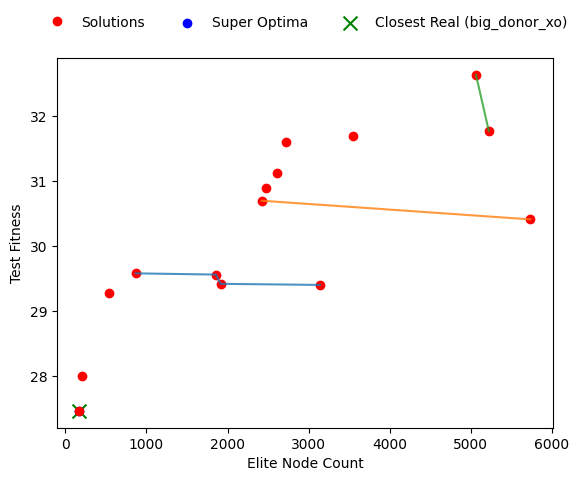

In [206]:
ppb_fronts, crossovers_pf_ppb, metrics_pf_ppb, best_xo_ppb = pareto_fronts(ppb_pf_paths)

### Istanbul

In [207]:
ista_pf_paths = {'fitness': "results/*ABS/istanbul_test_fitness.csv",
                'size': "results/*ABS/istanbul_elite_node_count.csv"}

elements in Pareto front 1: [3, 4]
elements in Pareto front 2: [0, 8]
elements in Pareto front 3: [5, 2, 6]
elements in Pareto front 4: [1]
elements in Pareto front 5: [11, 12, 13]
elements in Pareto front 6: [9, 10, 7]
elements in Pareto front 7: [14]
elements in Pareto front 8: []


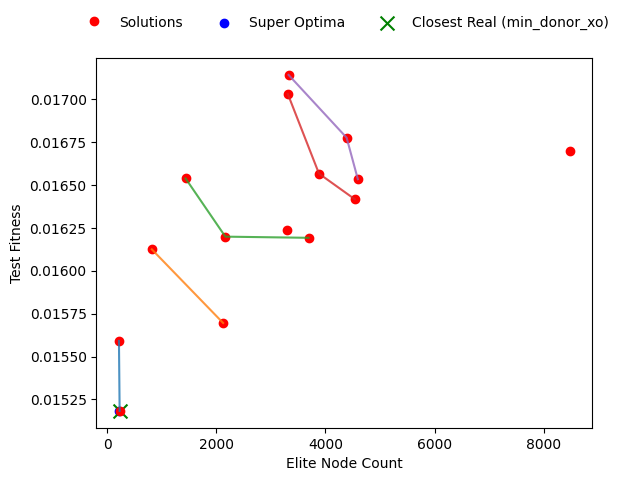

In [208]:
ista_fronts, crossovers_pf_ista, metrics_pf_ista, best_xo_ista = pareto_fronts(ista_pf_paths)

### Concrete_Slump

In [209]:
csl_pf_paths = {'fitness': "results/*ABS/concrete_slump_test_fitness.csv",
                'size': "results/*ABS/concrete_slump_elite_node_count.csv"}

elements in Pareto front 1: [0, 4, 13]
elements in Pareto front 2: [5, 14, 3, 7]
elements in Pareto front 3: [6, 11]
elements in Pareto front 4: [8, 1, 9, 12]
elements in Pareto front 5: [2]
elements in Pareto front 6: [10]
elements in Pareto front 7: []


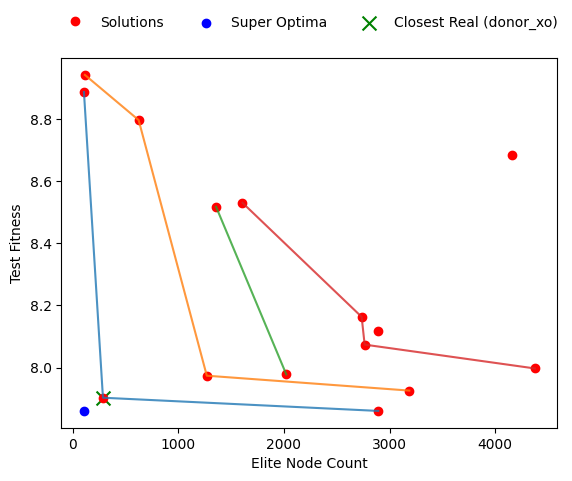

In [210]:
csl_fronts, crossovers_pf_csl, metrics_pf_csl, best_xo_csl  = pareto_fronts(csl_pf_paths)

In [221]:
crossovers_pf_csl

0            donor_xo
4        big_donor_xo
13    dif_big_donor_5
Name: crossover, dtype: object

In [222]:
metrics_pf_csl

(0     7.902542
 4     8.888523
 13    7.859973
 Name: test_fitness, dtype: float64,
 0      286.0
 4      106.0
 13    2893.0
 Name: elite_node_count, dtype: float64)

### Concrete_Strength

In [212]:
cst_pf_paths = {'fitness': "results/*ABS/concrete_strength_test_fitness.csv",
                'size': "results/*ABS/concrete_strength_elite_node_count.csv"}

elements in Pareto front 1: [0, 1, 3, 4, 5, 9, 11]
elements in Pareto front 2: [2, 6, 7, 12, 13]
elements in Pareto front 3: [10, 14]
elements in Pareto front 4: [8]
elements in Pareto front 5: []


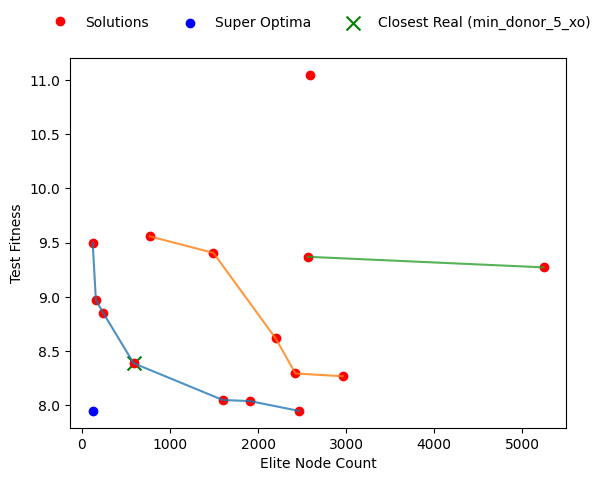

In [213]:
cst_fronts, crossovers_pf_cst, metrics_pf_cst,  best_xo_cst = pareto_fronts(cst_pf_paths)

In [223]:
crossovers_pf_cst

0            donor_xo
1          donor_5_xo
3        min_donor_xo
4        big_donor_xo
5      min_donor_5_xo
9         dif_donor_5
11    dif_min_donor_5
Name: crossover, dtype: object

In [224]:
metrics_pf_cst

(0     8.853224
 1     7.948952
 3     8.973259
 4     9.499298
 5     8.388457
 9     8.040199
 11    8.049399
 Name: test_fitness, dtype: float64,
 0      241.0
 1     2466.5
 3      158.5
 4      122.5
 5      587.0
 9     1904.0
 11    1600.5
 Name: elite_node_count, dtype: float64)

### RBSP

In [214]:
rbsp_pf_paths = {'fitness': "results/*ABS/rbsp_test_fitness.csv",
                'size': "results/*ABS/rbsp_elite_node_count.csv"}

elements in Pareto front 1: [0, 3, 4]
elements in Pareto front 2: [13, 5, 9, 11]
elements in Pareto front 3: [1, 8, 12]
elements in Pareto front 4: [7, 6]
elements in Pareto front 5: [10, 14]
elements in Pareto front 6: [2]
elements in Pareto front 7: []


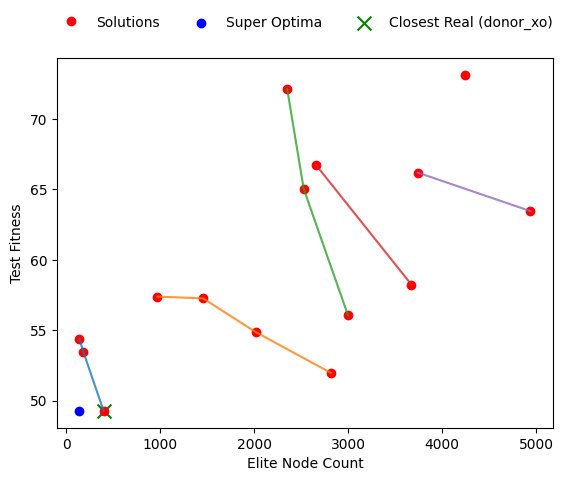

In [216]:
rbsp_fronts, crossovers_pf_rbsp, metrics_pf_rbsp, best_xo_rbsp = pareto_fronts(rbsp_pf_paths)

### Toxicity

In [217]:
tox_pf_paths = {'fitness': "results/*ABS/tox_test_fitness.csv",
                'size': "results/*ABS/tox_elite_node_count.csv"}

elements in Pareto front 1: [3, 4]
elements in Pareto front 2: [8, 0, 5]
elements in Pareto front 3: [6, 11]
elements in Pareto front 4: [2, 7, 13]
elements in Pareto front 5: [1, 9]
elements in Pareto front 6: [12]
elements in Pareto front 7: [10, 14]
elements in Pareto front 8: []


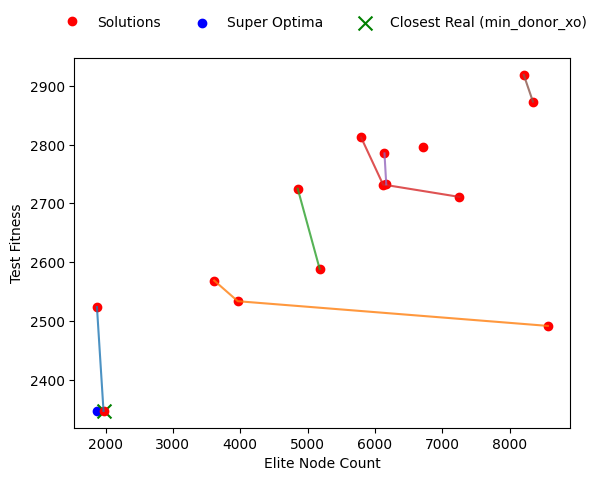

In [218]:
tox_fronts, crossovers_pf_tox, metrics_pf_tox, best_xo_tox= pareto_fronts(tox_pf_paths)

## SLIM+SIG2

### Toxicity

In [25]:
tox_fitness_xo = create_sets(toxicity_path, 'tox+', 'SLIM+SIG2', 1000, 'test_fitness',0.05)

doing, donor_xo
doing, donor_5_xo
doing, donor_25_xo
doing, min_donor_xo
doing, big_donor_xo
doing, min_donor_5_xo
doing, min_donor_25_xo
doing, big_donor_5_xo
doing, big_donor_25_xo
doing, dif_donor_5
doing, dif_donor_25
doing, dif_min_donor_5
doing, dif_min_donor_25
doing, dif_big_donor_5
doing, dif_big_donor_25
The best crossover in terms of test_fitness is dif_min_donor_25 with a median value of 2582.722412109375.

There is no statistical difference between dif_min_donor_25 and dif_big_donor_25
p_value = 0.0803273618221283
------------------------------------------------------------------------------------------
dif_donor_25 is statistically different from dif_min_donor_25 with a p_value of: 0.019660815596580505

The set of crossovers with the best test_fitness include:
          Crossover  test_fitness   p_value
0  dif_min_donor_25   2582.722412  0.000000
1  dif_big_donor_25   2583.605957  0.080327


In [229]:
tox_fitness_xo

Crossover  test_fitness   p_value
0  dif_min_donor_25   2582.722412  0.000000
1  dif_big_donor_25   2583.605957  0.080327

In [27]:
tox_size_xo = create_sets(toxicity_path, 'tox+', 'SLIM+SIG2', 1000, 'elite_node_count',0.05)

The best crossover in terms of elite_node_count is min_donor_xo with a median value of 2988.5.

big_donor_xo is statistically different from min_donor_xo with a p_value of: 0.03841841779649258

The set of crossovers with the best elite_node_count include:
      Crossover  elite_node_count  p_value
0  min_donor_xo            2988.5        0


In [230]:
tox_size_xo

Crossover  elite_node_count  p_value
0  min_donor_xo            2988.5        0

In [28]:
crossovers_tox = set(tox_fitness_xo['Crossover']) & set(tox_size_xo['Crossover'])
crossovers_tox

set()

### PPB

In [29]:
ppb_fitness_xo = create_sets(ppb_path, 'ppb+', 'SLIM+SIG2', 1000, 'test_fitness',0.05)

The best crossover in terms of test_fitness is big_donor_xo with a median value of 27.41040802001953.

There is no statistical difference between big_donor_xo and donor_25_xo
p_value = 0.4521643426269293
------------------------------------------------------------------------------------------
There is no statistical difference between big_donor_xo and dif_big_donor_5
p_value = 0.3817984350025654
------------------------------------------------------------------------------------------
There is no statistical difference between big_donor_xo and min_donor_25_xo
p_value = 0.6554384250193834
------------------------------------------------------------------------------------------
There is no statistical difference between big_donor_xo and dif_min_donor_5
p_value = 0.08406547829508781
------------------------------------------------------------------------------------------
There is no statistical difference between big_donor_xo and donor_xo
p_value = 0.370740607380867
-------------------

In [231]:
ppb_fitness_xo

Crossover  test_fitness   p_value
0       big_donor_xo     27.410408  0.000000
1        donor_25_xo     28.766115  0.452164
2    dif_big_donor_5     29.263870  0.381798
3    min_donor_25_xo     29.368563  0.655438
4    dif_min_donor_5     29.412760  0.084065
5           donor_xo     29.458559  0.370741
6    big_donor_25_xo     29.839951  0.157948
7       min_donor_xo     29.858276  0.477106
8         donor_5_xo     30.094201  0.063556
9   dif_min_donor_25     30.376491  0.057688
10    min_donor_5_xo     30.523302  0.066665
11  dif_big_donor_25     30.583475  0.253436

In [30]:
ppb_size_xo = create_sets(ppb_path, 'ppb+', 'SLIM+SIG2', 1000, 'elite_node_count',0.05)

The best crossover in terms of elite_node_count is big_donor_xo with a median value of 2100.5.

There is no statistical difference between big_donor_xo and min_donor_xo
p_value = 0.7538731576897046
------------------------------------------------------------------------------------------
donor_xo is statistically different from big_donor_xo with a p_value of: 1.862645149230957e-09

The set of crossovers with the best elite_node_count include:
      Crossover  elite_node_count   p_value
0  big_donor_xo            2100.5  0.000000
1  min_donor_xo            2154.0  0.753873


/opt/anaconda3/envs/test_env/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [ ]:
ppb_size_xo

In [31]:
crossovers_ppb = set(ppb_fitness_xo['Crossover']) & set(ppb_size_xo['Crossover'])
crossovers_ppb

{'big_donor_xo', 'min_donor_xo'}

### RBSP

In [32]:
rbsp_fitness_xo = create_sets(resid_build_sale_price_path, 'rbsp+', 'SLIM+SIG2', 1000, 'test_fitness',0.05)

The best crossover in terms of test_fitness is donor_5_xo with a median value of 129.9557342529297.

There is no statistical difference between donor_5_xo and dif_donor_5
p_value = 0.23665234446525574
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and dif_big_donor_5
p_value = 1.0
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and dif_min_donor_25
p_value = 0.5291051845997572
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and dif_min_donor_5
p_value = 0.370740607380867
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and big_donor_5_xo
p_value = 0.9676735773682594
---------------------------------------

In [232]:
rbsp_fitness_xo

Crossover  test_fitness   p_value
0        donor_5_xo    129.955734  0.000000
1       dif_donor_5    129.971878  0.236652
2   dif_big_donor_5    133.025383  1.000000
3  dif_min_donor_25    134.187332  0.529105
4   dif_min_donor_5    134.753128  0.370741
5    big_donor_5_xo    135.626472  0.967674

In [33]:
rbsp_size_xo = create_sets(resid_build_sale_price_path, 'rbsp+', 'SLIM+SIG2', 1000, 'elite_node_count',0.05)

The best crossover in terms of elite_node_count is min_donor_xo with a median value of 2475.5.

There is no statistical difference between min_donor_xo and big_donor_xo
p_value = 0.2988441474735737
------------------------------------------------------------------------------------------
donor_xo is statistically different from min_donor_xo with a p_value of: 1.862645149230957e-09

The set of crossovers with the best elite_node_count include:
      Crossover  elite_node_count   p_value
0  min_donor_xo            2475.5  0.000000
1  big_donor_xo            2493.5  0.298844


In [233]:
rbsp_size_xo

Crossover  elite_node_count   p_value
0  min_donor_xo            2475.5  0.000000
1  big_donor_xo            2493.5  0.298844

In [34]:
crossovers_rbsp = set(rbsp_fitness_xo['Crossover']) & set(rbsp_size_xo['Crossover'])
crossovers_rbsp

set()

### Concrete_Strength

In [35]:
cst_fitness_xo = create_sets(concrete_strength_path, 'concrete_strength+', 'SLIM+SIG2', 1000, 'test_fitness',0.05)

The best crossover in terms of test_fitness is donor_5_xo with a median value of 7.439790964126587.

There is no statistical difference between donor_5_xo and dif_donor_5
p_value = 0.24494642950594425
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and dif_min_donor_5
p_value = 0.6408254038542509
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and dif_big_donor_25
p_value = 0.07672121562063694
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and dif_big_donor_5
p_value = 0.08793856762349606
------------------------------------------------------------------------------------------
dif_min_donor_25 is statistically different from donor_5_xo with a p_value of: 0.000283263623714447

The set of crossovers 

In [234]:
cst_fitness_xo

Crossover  test_fitness   p_value
0        donor_5_xo      7.439791  0.000000
1       dif_donor_5      7.512923  0.244946
2   dif_min_donor_5      7.599888  0.640825
3  dif_big_donor_25      7.752748  0.076721
4   dif_big_donor_5      7.819327  0.087939

In [36]:
cst_size_xo = create_sets(concrete_strength_path, 'concrete_strength+', 'SLIM+SIG2', 1000, 'elite_node_count',0.05)

The best crossover in terms of elite_node_count is min_donor_xo with a median value of 1737.0.

There is no statistical difference between min_donor_xo and big_donor_xo
p_value = 0.42795460671186447
------------------------------------------------------------------------------------------
donor_xo is statistically different from min_donor_xo with a p_value of: 1.862645149230957e-09

The set of crossovers with the best elite_node_count include:
      Crossover  elite_node_count   p_value
0  min_donor_xo            1737.0  0.000000
1  big_donor_xo            1790.0  0.427955


In [236]:
cst_size_xo

Crossover  elite_node_count   p_value
0  min_donor_xo            1737.0  0.000000
1  big_donor_xo            1790.0  0.427955

In [37]:
crossovers_cst = set(cst_fitness_xo['Crossover']) & set(cst_size_xo['Crossover'])
crossovers_cst

set()

### Concrete Slump

In [43]:
csl_fitness_xo = create_sets(concrete_slump_path, 'concrete_slump+', 'SLIM+SIG2', 1000, 'test_fitness',0.05)

The best crossover in terms of test_fitness is donor_5_xo with a median value of 7.957578659057617.

There is no statistical difference between donor_5_xo and dif_big_donor_5
p_value = 0.7000329215079546
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and donor_25_xo
p_value = 0.9192965272814035
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and dif_min_donor_5
p_value = 0.6263462882488966
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and min_donor_5_xo
p_value = 0.7456546742469072
------------------------------------------------------------------------------------------
There is no statistical difference between donor_5_xo and min_donor_25_xo
p_value = 0.7456546742469072
-------------------------

In [237]:
csl_fitness_xo

Crossover  test_fitness   p_value
0         donor_5_xo      7.957579  0.000000
1    dif_big_donor_5      8.042921  0.700033
2        donor_25_xo      8.080171  0.919297
3    dif_min_donor_5      8.118476  0.626346
4     min_donor_5_xo      8.183029  0.745655
5    min_donor_25_xo      8.205535  0.745655
6    big_donor_25_xo      8.285252  0.427955
7   dif_min_donor_25      8.379507  0.983834
8     big_donor_5_xo      8.577576  0.439967
9       dif_donor_25      8.588928  0.427955
10      min_donor_xo      8.668059  0.871208
11  dif_big_donor_25      8.688789  0.640825
12          donor_xo      8.807783  0.839393
13      big_donor_xo      8.913942  0.967674

In [44]:
csl_size_xo = create_sets(concrete_slump_path, 'concrete_slump+', 'SLIM+SIG2', 1000, 'elite_node_count',0.05)

The best crossover in terms of elite_node_count is min_donor_xo with a median value of 1064.0.

big_donor_xo is statistically different from min_donor_xo with a p_value of: 0.03098480962216854

The set of crossovers with the best elite_node_count include:
      Crossover  elite_node_count  p_value
0  min_donor_xo            1064.0        0


In [239]:
csl_size_xo

Crossover  elite_node_count  p_value
0  min_donor_xo            1064.0        0

In [45]:
crossovers_csl = set(csl_fitness_xo['Crossover']) & set(csl_size_xo['Crossover'])
crossovers_csl

{'min_donor_xo'}

### Istanbul

In [46]:
ista_fitness_xo = create_sets(istanbul_path, 'istanbul+', 'SLIM+SIG2', 1000, 'test_fitness',0.05)

The best crossover in terms of test_fitness is min_donor_xo with a median value of 0.014847757294774.

min_donor_25_xo is statistically different from min_donor_xo with a p_value of: 0.034536734223365784

The set of crossovers with the best test_fitness include:
      Crossover  test_fitness  p_value
0  min_donor_xo      0.014848        0


In [240]:
ista_fitness_xo

Crossover  test_fitness  p_value
0  min_donor_xo      0.014848        0

In [47]:
ista_size_xo = create_sets(istanbul_path, 'istanbul+', 'SLIM+SIG2', 1000, 'elite_node_count',0.05)

The best crossover in terms of elite_node_count is big_donor_xo with a median value of 267.5.

There is no statistical difference between big_donor_xo and min_donor_xo
p_value = 0.2988441474735737
------------------------------------------------------------------------------------------
donor_xo is statistically different from big_donor_xo with a p_value of: 1.862645149230957e-09

The set of crossovers with the best elite_node_count include:
      Crossover  elite_node_count   p_value
0  big_donor_xo             267.5  0.000000
1  min_donor_xo             299.5  0.298844


In [241]:
ista_size_xo

Crossover  elite_node_count   p_value
0  big_donor_xo             267.5  0.000000
1  min_donor_xo             299.5  0.298844

In [48]:
crossovers_ista = set(ista_fitness_xo['Crossover']) & set(ista_size_xo['Crossover'])
crossovers_ista

{'min_donor_xo'}

## Pareto Fronts

### PPB

In [227]:
ppb_pf_paths = {'fitness': "results/+SIG2/ppb+_test_fitness.csv",
                'size': "results/+SIG2/ppb+_elite_node_count.csv"}

elements in Pareto front 1: [6]
elements in Pareto front 2: [0, 2, 3, 11, 13]
elements in Pareto front 3: [4, 5]
elements in Pareto front 4: [1, 7, 8]
elements in Pareto front 5: [12, 9]
elements in Pareto front 6: [10, 14]
elements in Pareto front 7: []


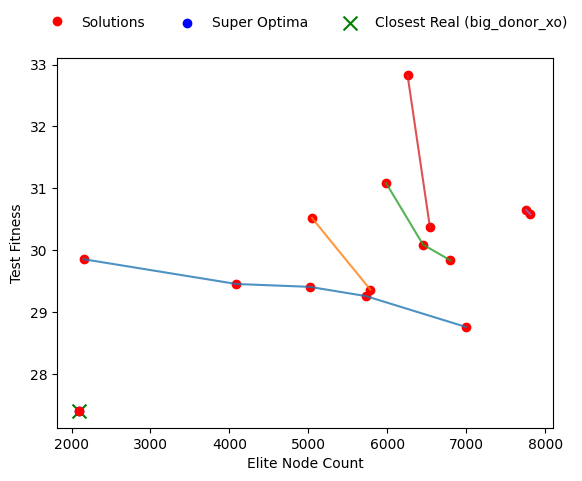

In [228]:
ppb_fronts, crossovers_pf_ppb, metrics_pf_ppb, best_xo_ppb = pareto_fronts(ppb_pf_paths)

### Istanbul

In [242]:
ista_pf_paths = {'fitness': "results/+SIG2/istanbul+_test_fitness.csv",
                'size': "results/+SIG2/istanbul+_elite_node_count.csv"}

elements in Pareto front 1: [3, 4]
elements in Pareto front 2: [2, 6, 0, 8]
elements in Pareto front 3: [5, 7, 13]
elements in Pareto front 4: [1, 9, 10, 14]
elements in Pareto front 5: [11, 12]
elements in Pareto front 6: []


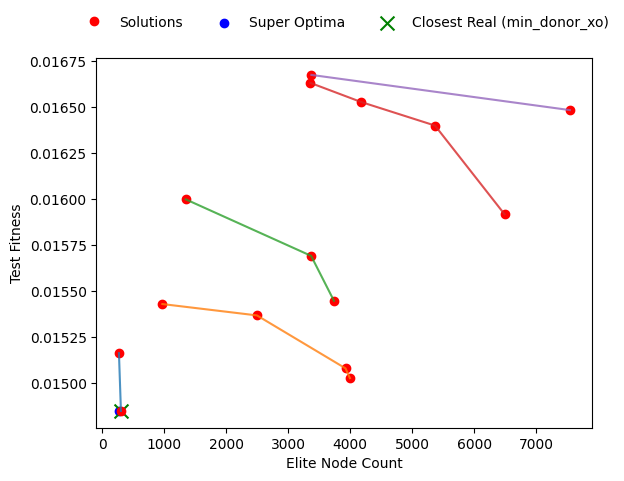

In [243]:
ista_fronts, crossovers_pf_ista, metrics_pf_ista, best_xo_ista = pareto_fronts(ista_pf_paths)

### Toxicity

In [246]:
tox_pf_paths = {'fitness': "results/+SIG2/tox+_test_fitness.csv",
                'size': "results/+SIG2/tox+_elite_node_count.csv"}

elements in Pareto front 1: [0, 3, 4, 9, 11, 12, 13, 14]
elements in Pareto front 2: [1, 8, 5, 10]
elements in Pareto front 3: [7, 2, 6]
elements in Pareto front 4: []


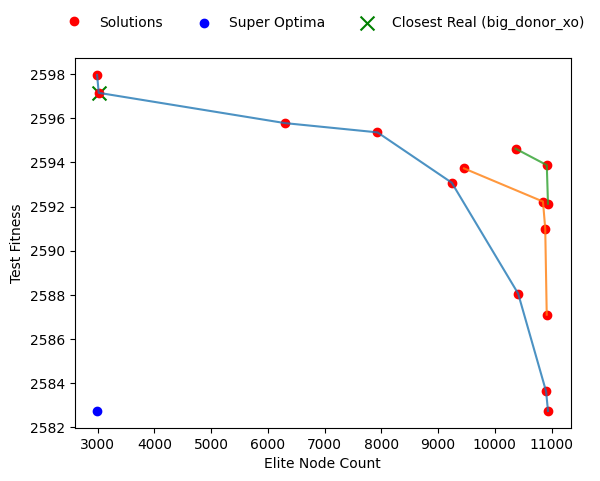

In [247]:
tox_fronts, crossovers_pf_tox, metrics_pf_tox, best_xo_tox = pareto_fronts(tox_pf_paths)

### RBSP

In [ ]:
rbsp_pf_paths = {'fitness': "results/+SIG2/rbsp+_test_fitness.csv",
                'size': "results/+SIG2/rbsp+_elite_node_count.csv"}

elements in Pareto front 1: [0, 3, 4]
elements in Pareto front 2: [13, 5, 9, 11]
elements in Pareto front 3: [1, 8, 12]
elements in Pareto front 4: [7, 6]
elements in Pareto front 5: [10, 14]
elements in Pareto front 6: [2]
elements in Pareto front 7: []


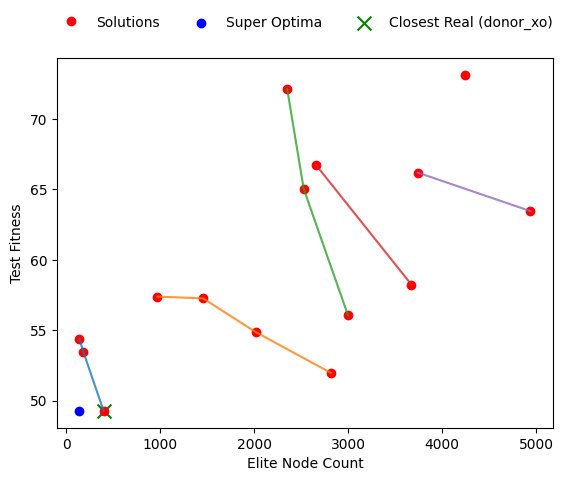

In [248]:
rbsp_fronts, crossovers_pf_rbsp, metrics_pf_rbsp, best_xo_rbsp = pareto_fronts(rbsp_pf_paths)

### Concrete Strength

In [250]:
cst_pf_paths = {'fitness': "results/+SIG2/concrete_strength+_test_fitness.csv",
                'size': "results/+SIG2/concrete_strength+_elite_node_count.csv"}

elements in Pareto front 1: [0, 1, 3, 11]
elements in Pareto front 2: [5, 9, 4]
elements in Pareto front 3: [7, 13, 14, 6]
elements in Pareto front 4: [12, 2]
elements in Pareto front 5: [10]
elements in Pareto front 6: [8]
elements in Pareto front 7: []


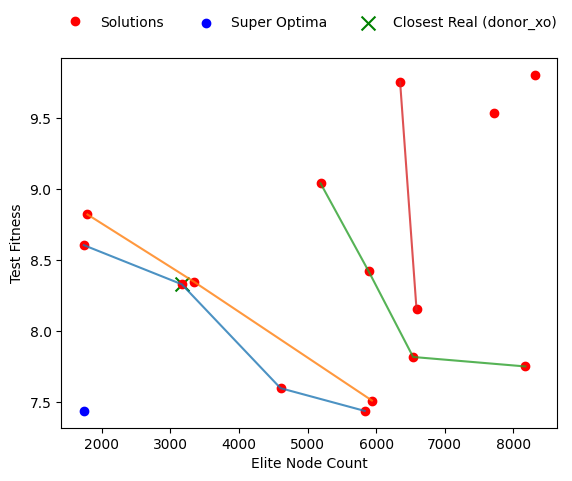

In [251]:
cst_fronts, crossovers_pf_cst, metrics_pf_cst, best_xo_cst = pareto_fronts(cst_pf_paths)

In [252]:
crossovers_pf_cst

0            donor_xo
1          donor_5_xo
3        min_donor_xo
11    dif_min_donor_5
Name: crossover, dtype: object

In [253]:
metrics_pf_cst

(0     8.330888
 1     7.439791
 3     8.606113
 11    7.599888
 Name: test_fitness, dtype: float64,
 0     3165.5
 1     5833.5
 3     1737.0
 11    4605.5
 Name: elite_node_count, dtype: float64)

### Concrete Slump

In [254]:
csl_pf_paths = {'fitness': "results/+SIG2/concrete_slump+_test_fitness.csv",
                'size': "results/+SIG2/concrete_slump+_elite_node_count.csv"}

elements in Pareto front 1: [1, 3, 5, 11]
elements in Pareto front 2: [13, 0, 4, 6]
elements in Pareto front 3: [2, 7, 12]
elements in Pareto front 4: [8, 9]
elements in Pareto front 5: [10]
elements in Pareto front 6: [14]
elements in Pareto front 7: []


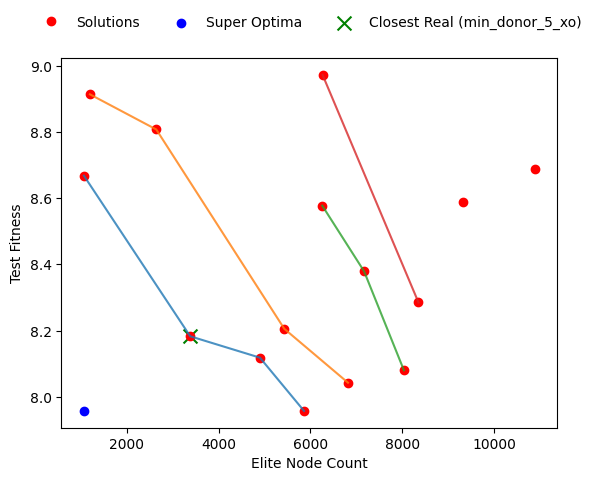

In [256]:
csl_fronts, crossovers_pf_csl, metrics_pf_csl, best_xo_csl = pareto_fronts(csl_pf_paths)

In [257]:
crossovers_pf_csl

1          donor_5_xo
3        min_donor_xo
5      min_donor_5_xo
11    dif_min_donor_5
Name: crossover, dtype: object

In [258]:
metrics_pf_csl

(1     7.957579
 3     8.668059
 5     8.183029
 11    8.118476
 Name: test_fitness, dtype: float64,
 1     5861.0
 3     1064.0
 5     3380.5
 11    4899.5
 Name: elite_node_count, dtype: float64)